In [1]:
!source ~/.bashrc

In [6]:
import numpy as np
import pandas as pd
import glob
import itertools
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from src.helper import *

In [7]:
def interp(x, y, age):
    f = interp1d(x, y, fill_value="extrapolate", kind="cubic")
    return f(age)

mode_labels = ["n1ell0m0","n2ell0m0","n3ell0m0","n4ell0m0","n5ell0m0","n6ell0m0","n7ell0m0","n8ell0m0","n9ell0m0","n10ell0m0",
         "n1ell1mm1","n2ell1mm1","n3ell1mm1","n4ell1mm1","n5ell1mm1","n6ell1mm1","n7ell1mm1","n8ell1mm1","n9ell1mm1","n10ell1mm1",
         "n1ell1m0","n2ell1m0","n3ell1m0","n4ell1m0","n5ell1m0","n6ell1m0","n7ell1m0","n8ell1m0","n9ell1m0","n10ell1m0",
         "n1ell1mp1","n2ell1mp1","n3ell1mp1","n4ell1mp1","n5ell1mp1","n6ell1mp1","n7ell1mp1","n8ell1mp1","n9ell1mp1","n10ell1mp1"]
mode_strings = ["100","200","300","400","500","600","700","800","900","1000",
         "11-1","21-1","31-1","41-1","51-1","61-1","71-1","81-1","91-1","101-1",
         "110","210","310","410","510","610","710","810","910","1010",
         "11-1","21-1","31-1","41-1","51-1","61-1","71-1","81-1","91-1","101-1"]

def get_freqs(freqs, ages, ind):
    dff = pd.DataFrame()
    dff["Dnu"] = np.repeat(0, len(freqs))
    dff["eps"] = np.repeat(0, len(freqs))
    for s in mode_labels:
        dff[s] = np.repeat(0, len(freqs))

    freqs_df = []
    for i, row in dff.iterrows():
        df = row
        ts = freqs[i]
        ts = model_nlm(ts)
        df["age"] = ages.iloc[i]
        df["Dnu"] = model_Dnu(ts)
        df["eps"] = model_epsilon(ts)
        for j,s in enumerate(mode_strings):
            try:
                df[mode_labels[j]] = np.round(ts.query(f"nlm=='{s}'")["Re(freq)"].values[0],5)
            except:
                df[mode_labels[j]] = 0
        freqs_df.append(df)

    freqs_df = pd.DataFrame(freqs_df)

    l = 1
    for n in range(1, 11):
        freqs_df[f"n{n}ell{l}dfreq"] = freqs_df[f"n{n}ell{l}m0"] - freqs_df[f"n{n}ell{l}mm1"]
        freqs_df.drop(columns=[f"n{n}ell{l}mp1", f"n{n}ell{l}mm1"], inplace=True)
    columns = ['age', 'Dnu', 'eps', 'n1ell0m0', 'n2ell0m0', 'n3ell0m0', 'n4ell0m0',
    'n5ell0m0', 'n6ell0m0', 'n7ell0m0', 'n8ell0m0', 'n9ell0m0', 'n10ell0m0',
    'n1ell1m0', 'n2ell1m0', 'n3ell1m0', 'n4ell1m0', 'n5ell1m0', 'n6ell1m0',
    'n7ell1m0', 'n8ell1m0', 'n9ell1m0', 'n10ell1m0', 'n1ell1dfreq',
    'n2ell1dfreq', 'n3ell1dfreq', 'n4ell1dfreq', 'n5ell1dfreq',
    'n6ell1dfreq', 'n7ell1dfreq', 'n8ell1dfreq', 'n9ell1dfreq',
    'n10ell1dfreq']
    freqs_df = freqs_df[columns]
    return freqs_df

In [8]:
def get_data_dict(test_inputs):
    data_dict = {}
    k = 0
    for i, row in test_inputs.iterrows():
        m, z, v, key, log_dir = row
        print(row)
        hist, freqs, profs, n_profs, prof_index = get_data(log_dir)
        models = prof_index[prof_index.profile_number.isin(n_profs)].model_number
        hist = hist[hist.model_number.isin(models)]
        ages = hist.star_age/1e6
        data_dict[key] = pd.DataFrame()
        data_dict[key]['age'] = hist['star_age']/1e6
        data_dict[key]['log_cntr_Rho'] = hist['log_cntr_Rho'].values
        data_dict[key]['log_cntr_T'] = hist['log_cntr_T'].values
        data_dict[key]['log_Teff'] = hist['log_Teff'].values
        data_dict[key]['log_L'] = hist['log_L'].values
        data_dict[key]['log_Lnuc'] = hist['log_Lnuc'].values
        data_dict[key] = pd.merge(data_dict[key], get_freqs(freqs, ages, k), on="age")
        # ages = np.arange(0, data_dict[key].iloc[-1]["age"], 0.1)
        # new_df = pd.DataFrame()
        # new_df["age"] = ages
        # for column in data_dict[key].columns[1:]:
        #     new_df[column] = interp(data_dict[key]["age"], data_dict[key][column], ages)
        # data_dict[key] = new_df
        k += 1
    return data_dict

In [9]:
log_dirs = glob.glob("test1/*/LOGS")
m = [float(name.split("/")[1].split("_")[0].split("m")[1]) for name in log_dirs]
z = [float(name.split("/")[1].split("_")[1].split("z")[1]) for name in log_dirs]
v = [float(name.split("/")[1].split("_")[2].split("v")[1]) for name in log_dirs]
keys = [f"M={m[i]}_Z={z[i]}_V={v[i]}" for i in range(len(m))]
inputs = pd.DataFrame(np.array([m, z, v, keys, log_dirs]).T, columns=['m', 'z', 'v', 'key', 'log_dir'])
inputs = inputs.astype({'m': float, 'z': float, 'v': float, 'key': str, 'log_dir': str})
inputs.sort_values(by='m', inplace=True)
inputs.reset_index(drop=True, inplace=True)

In [12]:
test_inputs = inputs.query("m==1.7 and z==0.015")
test_inputs = test_inputs.sort_values(by='z')
data_dict = get_data_dict(test_inputs)

m                                1.7
z                              0.015
v                                0.0
key              M=1.7_Z=0.015_V=0.0
log_dir    test1/m1.7_z0.015_v0/LOGS
Name: 0, dtype: object

Text(0, 0.5, '$\\Delta\\nu$ (d$^{-1}$)')

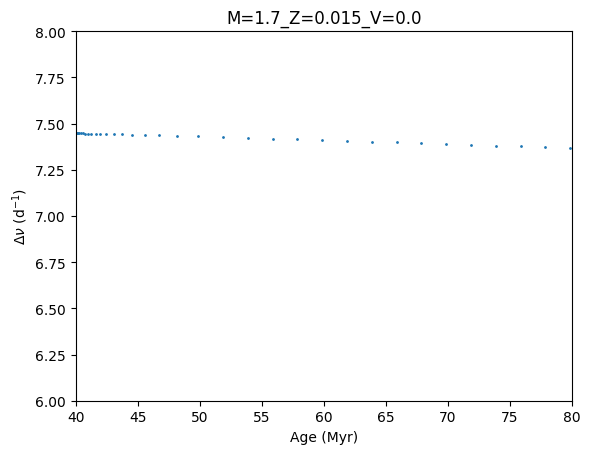

In [18]:
key = "M=1.7_Z=0.015_V=0.0"
age = data_dict[key]["age"]
Dnu = data_dict[key]["Dnu"]

plt.scatter(age, Dnu, s=1)
# plt.xlim(0, 40)
plt.xlim(40, 80)
plt.ylim(6, 8)
plt.xlabel("Age (Myr)")
plt.title(key)
plt.ylabel(r"$\Delta\nu$ (d$^{-1}$)")

ValueError: Filled contours require at least 2 levels.

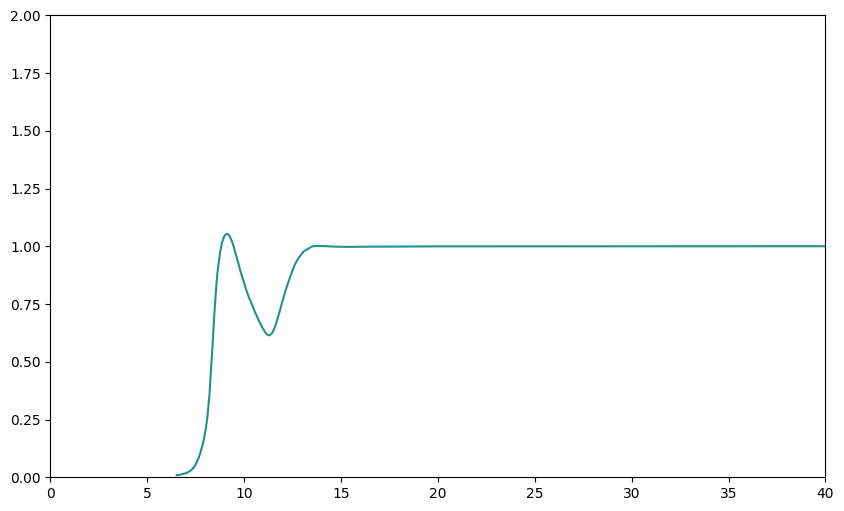

In [17]:
fig = plt.figure(figsize=(10,6))
palette = sns.color_palette("viridis", len(test_inputs))
ax1 = plt.subplot(1,1,1)
for i, key in enumerate(data_dict.keys()):
    plt.plot(data_dict[key]["age"], 10**data_dict[key]["log_Lnuc"]/10**data_dict[key]["log_L"], label=key, color=palette[i])
plt.xlim(0, 40)
plt.ylim(0,2)


Z = [[0,0],[0,0]]
levels = test_inputs["z"].values
contour = plt.contourf(Z, levels, cmap=mpl.colors.ListedColormap(palette))
cb = plt.colorbar(contour, ticks=levels, boundaries=levels, label='Metallicity')
plt.ylim(0, 1.2)
plt.show()